# Introduction

## Reference
https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models/notebook

https://www.kaggle.com/pestipeti/eda-plant-pathology-2020

# something might help

0. Seed everything ---[reproducible](https://pytorch.org/docs/stable/notes/randomness.html)
1. Get know your data, Do data laundry, Take care of the imbalance dataset ---[dealing with imbalanced Classification ](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
2. 合适的 augmentation method ---[Fast AutoAugment](https://github.com/kakaobrain/fast-autoaugment) [RandAugment](https://arxiv.org/abs/1909.13719)
3. 合适的 lr schedule 方法 ---[LR_schedule](https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling)
4. APEX ---[Automatic Mixed Precision](https://pytorch.org/blog/accelerating-training-on-nvidia-gpus-with-pytorch-automatic-mixed-precision/)
4. Model Selection ---[TIMM](https://paperswithcode.com/lib/timm)
5. Cross-validation, TTA ---[Stratified k-fold](https://scikit-learn.org/stable/modules/cross_validation.html#:~:text=3.1.2.2.1.-,Stratified%20k-fold,-%C2%B6) [When and Why TTA](https://arxiv.org/abs/2011.11156)
5. 合适的 Metric method ---[quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

## Content
* [EDA](#section-ONE)
    - [Import Dataset](#subsection-import)
    - [Image Meta Data](#subsection-meta)
    - [Visualize The Data](#subsection-visualize)
    - [Noisy in Data](#subsection-noisy)
    - [Canny edge detection](#subsection-canny)
* [Image Augmentation](#section-TWO)
    - [Albumentations](#subsection-albumentations)
    - [AutoAlbument](#subsection-autoaug)
    - [RangomAug](#subsection-randomaug)
* [Model](#section-THREE)
    - [Model Collection](#subsection-collection)
* [Training Process](#section-FOUR)
    - [Config](#subsection-Config)
    - [Prepare Data](#section-PData)
    - [Model](#section-Model)
    - [Train Loop](#section-Loop)
* [Inference Process](#section-FIVE)
    
 GL&HF Kaggling :D
    

<a id="section-ONE"></a>
# EDA

<a id="subsection-import"></a>
## Import Dataset

In [2]:
import numpy as np
import pandas as pd

import cv2
import hashlib
import matplotlib.pyplot as plt

import PIL
from PIL import Image
from PIL import ImageStat

from tqdm.notebook import tqdm

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [5]:
!pip install -U albumentations
import albumentations
albumentations.__version__

     |████████████████████████████████| 98 kB 396 kB/s eta 0:00:01
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


'1.0.0'

In [6]:
CFG = {
    'rootdir': '../input/classify-leaves/'
}

In [7]:
train = pd.read_csv(CFG['rootdir'] + 'train.csv')
test = pd.read_csv(CFG['rootdir'] + 'test.csv')
submission_sample = pd.read_csv(CFG['rootdir'] + 'sample_submission.csv')

In [8]:
train.sample(10)

image                   label
10034  images/10034.jpg           cedrus_libani
8865    images/8865.jpg        quercus_stellata
14823  images/14823.jpg  chionanthus_virginicus
3860    images/3860.jpg             picea_abies
12580  images/12580.jpg            malus_pumila
14377  images/14377.jpg            acer_ginnala
153      images/153.jpg           acer_palmatum
1843    images/1843.jpg     chionanthus_retusus
3979    images/3979.jpg           malus_baccata
14322  images/14322.jpg             salix_nigra

In [9]:
test.sample(10)

image
6400  images/24753.jpg
97    images/18450.jpg
365   images/18718.jpg
8076  images/26429.jpg
3672  images/22025.jpg
5650  images/24003.jpg
8489  images/26842.jpg
1645  images/19998.jpg
8577  images/26930.jpg
8493  images/26846.jpg

In [10]:
print(train.shape)
print(test.shape)

(18353, 2)
(8800, 1)


In [11]:
train.label.value_counts()

maclura_pomifera            353
ulmus_rubra                 235
prunus_virginiana           223
acer_rubrum                 217
broussonettia_papyrifera    214
                           ... 
ailanthus_altissima          58
ulmus_procera                58
crataegus_crus-galli         54
evodia_daniellii             53
juniperus_virginiana         51
Name: label, Length: 176, dtype: int64

176 labes in dataset

In [12]:
submission_sample.head()

image                   label
0  images/18353.jpg      halesia_tetraptera
1  images/18354.jpg   robinia_pseudo-acacia
2  images/18355.jpg  chionanthus_virginicus
3  images/18356.jpg         ulmus_americana
4  images/18357.jpg           picea_pungens

Lets disply a single image


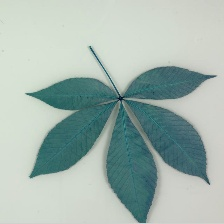

In [13]:
fig = px.imshow(cv2.imread(CFG['rootdir']+'{}'.format(train.sample(1)['image'].values[0])))
fig.show()

<a id="subsection-meta"></a>
## Image Meta Data

In [14]:
def get_hash(image):
    md5 = hashlib.md5()
    md5.update(np.array(image).tobytes())
    return md5.hexdigest()

def get_image_meta(image_id, image_src, dataset = 'train'):
    img = Image.open(image_src)
    extrema = img.getextrema()
    stat = ImageStat.Stat(img)
    
    meta = {
        'image': image_id,
        'dataset': dataset,
        'hash': get_hash(img),
        'R_min': extrema[0][0],
        'R_max': extrema[0][1],
        'G_min': extrema[1][0],
        'G_max': extrema[1][1],
        'B_min': extrema[2][0],
        'B_max': extrema[2][1],
        'R_avg': stat.mean[0],
        'G_avg': stat.mean[1],
        'B_avg': stat.mean[2],
        'height': img.height,
        'width': img.width,
        'format': img.format,
        'mode': img.mode
    }
    return meta

In [15]:
def image_metadata(df, rootdir, mark='train'):
    img_data = []
    for i, image_id in enumerate(tqdm(df['image'], total=df.shape[0])):
        img_data.append(get_image_meta(image_id, (CFG['rootdir'] + '{}'.format(image_id)), mark))
    
    meta_pd = pd.DataFrame(img_data)
    return meta_pd

In [16]:
meta_train = image_metadata(df=train, rootdir = CFG['rootdir'], mark='train')
meta_train.head()

  0%|          | 0/18353 [00:00<?, ?it/s]

image dataset                              hash  R_min  R_max  \
0  images/0.jpg   train  a3e451f614ef9d30f8ce40c5d3ab26e9     11    255   
1  images/1.jpg   train  d8a7f4f3d77ede21fdf08057f2cc2a76     29    212   
2  images/2.jpg   train  2fab616c550dffbd7c77cc83db527f55     53    255   
3  images/3.jpg   train  bf7965f72a8ea292298ef0f8d38e1d94     56    255   
4  images/4.jpg   train  c8cd255ec32df9475bf262d176247b1c     29    205   

   G_min  G_max  B_min  B_max       R_avg       G_avg       B_avg  height  \
0     12    255     10    255  242.714146  243.177794  242.640246     224   
1     34    217     26    213  188.788006  195.295480  188.551459     224   
2     55    255     53    255  235.176160  235.877730  234.513293     224   
3     56    255     56    255  231.735830  232.241908  231.272999     224   
4     32    212     30    207  188.485850  197.165996  189.786910     224   

   width format mode  
0    224   JPEG  RGB  
1    224   JPEG  RGB  
2    224   JPEG  RGB  
3    224   JPEG  RGB  
4    224   JPEG  RGB

In [17]:
meta_test = image_metadata(test, rootdir = CFG['rootdir'], mark='test')
meta_test.head()

  0%|          | 0/8800 [00:00<?, ?it/s]

image dataset                              hash  R_min  R_max  \
0  images/18353.jpg    test  0791515dfa647ef28404409a5e19248a      9    185   
1  images/18354.jpg    test  b67ca37e9496ef024be0f4ca979f0754      8    195   
2  images/18355.jpg    test  b95c7910bc565abe7fed2655d78b2044      2    255   
3  images/18356.jpg    test  8f9df1975fcf3365a8818dc5100a0750     28    215   
4  images/18357.jpg    test  c4b93f84fba230e47da6e0b828dfc809     10    250   

   G_min  G_max  B_min  B_max       R_avg       G_avg       B_avg  height  \
0     18    190      0    186  129.379504  133.808494  126.382972     224   
1     13    189      0    191  134.952507  138.653021  131.411651     224   
2      3    255      0    255  226.100566  227.091538  223.575275     224   
3     40    222     28    221  197.032087  208.234076  202.516163     224   
4     20    245      0    241  130.410535  133.729253  120.305584     224   

   width format mode  
0    224   JPEG  RGB  
1    224   JPEG  RGB  
2    224   JPEG  RGB  
3    224   JPEG  RGB  
4    224   JPEG  RGB

<a id="subsection-visualize"></a>
## Visualize The Data

In [18]:
fig = px.histogram(train, 'label', marginal='violin', hover_data=train.columns)
fig.update_layout(title_text="Distribution of Classes")
fig.show()

Here we can see that the distribution seems like a long-tail dataset, and our testing data set might based on 176 x 50 = 88800 (with an even distribution). 

这里可以看到，我们的训练集看起来有那么一点点像long-tail的数据集, 并且因为目标测试集应该是按照 176 X 50 = 8800(按照均匀分布).
所以我们取sampler的时候需要注意，还有cross validation, 也要注意每个fold的分法.

In [19]:
fig = ff.create_distplot([meta_train['R_avg']], group_labels=["ChannelsR"], colors=["RED"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of Channel Values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [20]:
fig = ff.create_distplot([meta_train['R_avg'], meta_train['G_avg'], meta_train['B_avg']], group_labels=['R','G','B'], colors=["RED",'GREEN','BLUE'])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of Channel Values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5
fig

In [21]:
fig = go.Figure()

for idx, values in enumerate([meta_train['R_avg'], meta_train['G_avg'], meta_train['B_avg']]):
    if idx == 0:
        color = "RED"
    if idx == 1:
        color = "GREEN"
    if idx == 2:
        color = "BLUE"
    fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color=color.lower())))
    
fig.update_layout(yaxis_title="Mean Value", xaxis_title="Color Channel",
                  title="Mean Value vs. Color Channel", template="plotly_white")

We can see that RGB channel plot are mostly over lapped, since there are a lot of white space in out image data. The white channel [255,255,255] raised a lot of our average level. A boundbox might can help us reduce those useless pixels.(TBD)

通过查看RGB的channel图, 可以看到到RGB通道大致上都非常接近. 主要原因是图片集中有太多的空白, 所以[255,255,255]的数值过多,导致平均数值也很高.
也许可以考虑通过加一个boundbox来缩小搜索范围.

<a id="subsection-noisy"></a>
## Noisy in Data

In [22]:
def get_duplicate(dt, mark = 'train'):
    dup = dt.groupby(by = 'hash')[['dataset']].count().reset_index()
    dup = dup[dup['dataset'] > 1]
    dup.reset_index(drop = True, inplace = True)
    dup = dup.merge(dt[['image', 'hash']], on = 'hash')
    dup['dup_number'] = dup['dataset']
    dup.loc[:,'dataset'] = mark
    
    return dup

In [23]:
dup_train = get_duplicate(meta_train, 'train')
dup_train

hash dataset             image  dup_number
0    004ebc4c323e94d7fd5a88e00c4686dc   train   images/4200.jpg           2
1    004ebc4c323e94d7fd5a88e00c4686dc   train   images/8740.jpg           2
2    01e5f911777069d334c8af88cc28860c   train  images/11368.jpg           2
3    01e5f911777069d334c8af88cc28860c   train  images/11750.jpg           2
4    055a9310e58bf1305fac8c00fa5060d2   train   images/1274.jpg           2
..                                ...     ...               ...         ...
724  fde2210239d1504b3876f3d5d39141b4   train  images/16746.jpg           2
725  fec9a6addbe2ff34503b21371fe3ff5e   train  images/11987.jpg           2
726  fec9a6addbe2ff34503b21371fe3ff5e   train  images/13734.jpg           2
727  ffd2c8aeace5466200421028ab12e5bd   train    images/481.jpg           2
728  ffd2c8aeace5466200421028ab12e5bd   train   images/3303.jpg           2

[729 rows x 4 columns]

In [24]:
duptest = get_duplicate(meta_test, 'test')
duptest

hash dataset             image  dup_number
0   0b0641bac67b9e7e078c75956ad0f1c6    test  images/22349.jpg           2
1   0b0641bac67b9e7e078c75956ad0f1c6    test  images/26285.jpg           2
2   0bbc13fceea7e1bc75cc66125978ecae    test  images/23437.jpg           2
3   0bbc13fceea7e1bc75cc66125978ecae    test  images/25051.jpg           2
4   13f02dfca9a48781f13726aca0f52329    test  images/19337.jpg           2
..                               ...     ...               ...         ...
67  f431271ed2abc8fd4818b1576f3702c8    test  images/24078.jpg           2
68  f4e913f0ea819969ab3831797ca578c8    test  images/18836.jpg           2
69  f4e913f0ea819969ab3831797ca578c8    test  images/19155.jpg           2
70  f7550d07fb656f400476b49715ea0392    test  images/23069.jpg           2
71  f7550d07fb656f400476b49715ea0392    test  images/23383.jpg           2

[72 rows x 4 columns]

In [25]:
duptest['dup_number'].value_counts()

2    62
3     6
4     4
Name: dup_number, dtype: int64

Add label to our dup dataset

In [26]:
dup_train = dup_train.merge(train[['image','label']], on = 'image')
dup_train

hash dataset             image  dup_number  \
0    004ebc4c323e94d7fd5a88e00c4686dc   train   images/4200.jpg           2   
1    004ebc4c323e94d7fd5a88e00c4686dc   train   images/8740.jpg           2   
2    01e5f911777069d334c8af88cc28860c   train  images/11368.jpg           2   
3    01e5f911777069d334c8af88cc28860c   train  images/11750.jpg           2   
4    055a9310e58bf1305fac8c00fa5060d2   train   images/1274.jpg           2   
..                                ...     ...               ...         ...   
724  fde2210239d1504b3876f3d5d39141b4   train  images/16746.jpg           2   
725  fec9a6addbe2ff34503b21371fe3ff5e   train  images/11987.jpg           2   
726  fec9a6addbe2ff34503b21371fe3ff5e   train  images/13734.jpg           2   
727  ffd2c8aeace5466200421028ab12e5bd   train    images/481.jpg           2   
728  ffd2c8aeace5466200421028ab12e5bd   train   images/3303.jpg           2   

                     label  
0        prunus_virginiana  
1       prunus_subhirtella  
2         prunus_sargentii  
3    quercus_muehlenbergii  
4         maclura_pomifera  
..                     ...  
724           ulmus_pumila  
725   cryptomeria_japonica  
726   cryptomeria_japonica  
727   cryptomeria_japonica  
728   cryptomeria_japonica  

[729 rows x 5 columns]

In [27]:
tester = dup_train.copy()
# we will drop those rows both have the same hash and label which just duplicated data, not noisy confusion data.
#把 hash和 label都相同的 drop掉
tester = tester.drop_duplicates(subset=['hash','label'], keep=False)

In [28]:
tester['dup_number'].value_counts()

2    112
3     39
Name: dup_number, dtype: int64

In [29]:
tester.head(10)

hash dataset             image  dup_number  \
0   004ebc4c323e94d7fd5a88e00c4686dc   train   images/4200.jpg           2   
1   004ebc4c323e94d7fd5a88e00c4686dc   train   images/8740.jpg           2   
2   01e5f911777069d334c8af88cc28860c   train  images/11368.jpg           2   
3   01e5f911777069d334c8af88cc28860c   train  images/11750.jpg           2   
14  0ebfcf142008592147cc990f0ce2bc73   train  images/12740.jpg           2   
15  0ebfcf142008592147cc990f0ce2bc73   train  images/17561.jpg           2   
16  10d5d7b0bc4b97e24a31acbc7f96de7a   train  images/10758.jpg           2   
17  10d5d7b0bc4b97e24a31acbc7f96de7a   train  images/17521.jpg           2   
26  13ebf04d03a0089b06da7720f24c0258   train     images/50.jpg           2   
27  13ebf04d03a0089b06da7720f24c0258   train   images/3967.jpg           2   

                    label  
0       prunus_virginiana  
1      prunus_subhirtella  
2        prunus_sargentii  
3   quercus_muehlenbergii  
14      magnolia_stellata  
15     magnolia_tripetala  
16     magnolia_tripetala  
17      magnolia_stellata  
26      prunus_virginiana  
27     prunus_subhirtella

In [30]:
def plot_dup(df, number):
    fig, ax = plt.subplots(int(number/2), 2, figsize=(10, 30))
    ax = ax.flatten()

    for i in range(0, min(tester.shape[0], number), 2):
        image_i = cv2.imread(CFG['rootdir'] + '{}'.format(df.iloc[i, 2]), cv2.IMREAD_COLOR)
        image_i = cv2.cvtColor(image_i, cv2.COLOR_BGR2RGB)
        ax[i].set_axis_off()
        ax[i].imshow(image_i)
        ax[i].set_title(df.iloc[i, 2] + '\n' + df.iloc[i, 4])

        image_i_1 = cv2.imread(CFG['rootdir'] + '{}'.format(df.iloc[i + 1, 2]), cv2.IMREAD_COLOR)
        image_i_1 = cv2.cvtColor(image_i_1, cv2.COLOR_BGR2RGB)
        ax[i + 1].set_axis_off()
        ax[i + 1].imshow(image_i_1)
        ax[i + 1].set_title(df.iloc[i + 1, 2] + '\n' + df.iloc[i + 1,4])

In [ ]:
#plot_dup(dup_train, 12)

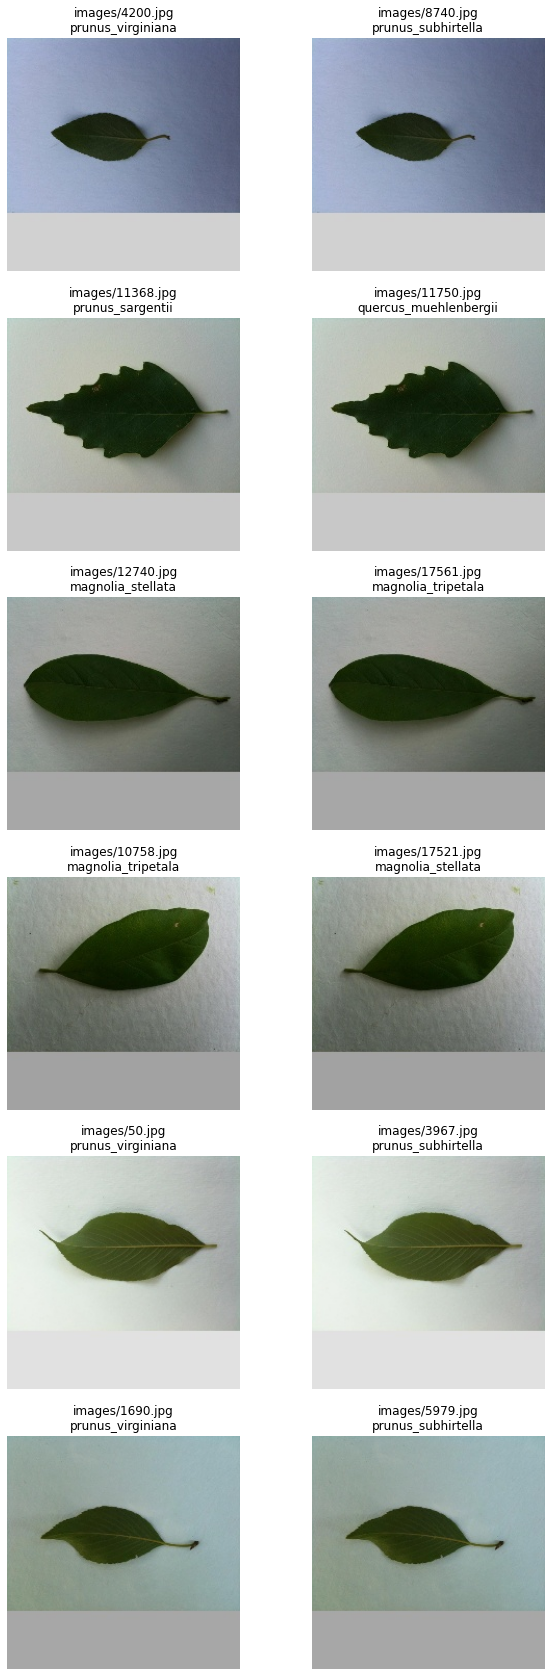

In [31]:
plot_dup(tester, 12)

Here, we will drop the duplicated row. 

这里可以选择考虑把dup的数据全都drop掉, 或者也可以加上soft label.

In [32]:
train_clean = train[~train['image'].isin(tester['image'])].reset_index(drop=True)

In [33]:
train_clean.nunique()

image    18202
label      176
dtype: int64

In [49]:
#save cleaned data
train_clean.to_csv('train_clean.csv', index=False)

<a id="subsection-canny"></a>
## Canny edge detection

https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

Here we use canny algorithm to search the edge, then we use the bound of edge to estimate our bounding.

这里使用的方法是用canny找出轮廓后，然后根据轮廓边界画出bounding box

In [34]:
def edge_and_cut(img_src):
    img = cv2.imread(img_src)
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-5:row_min+5, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-5:row_max+5, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-5:col_min+5] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-5:col_max+5] = [255, 0, 0]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

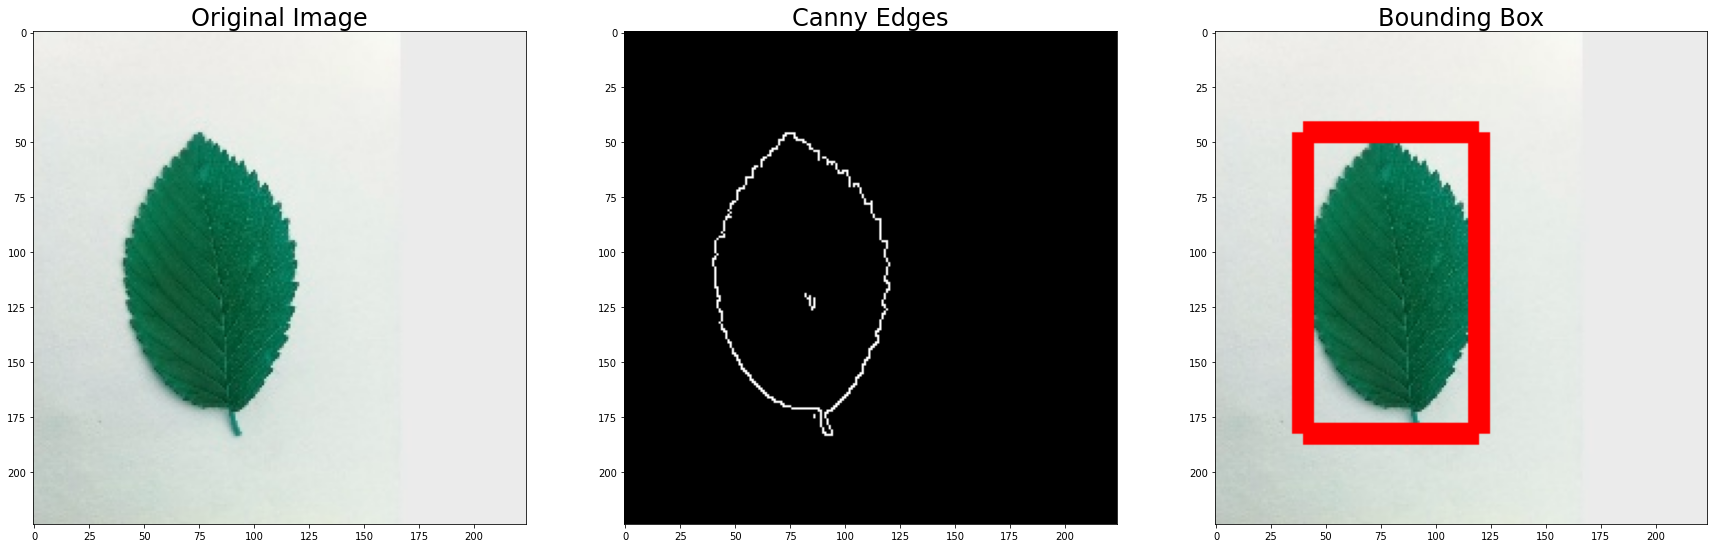

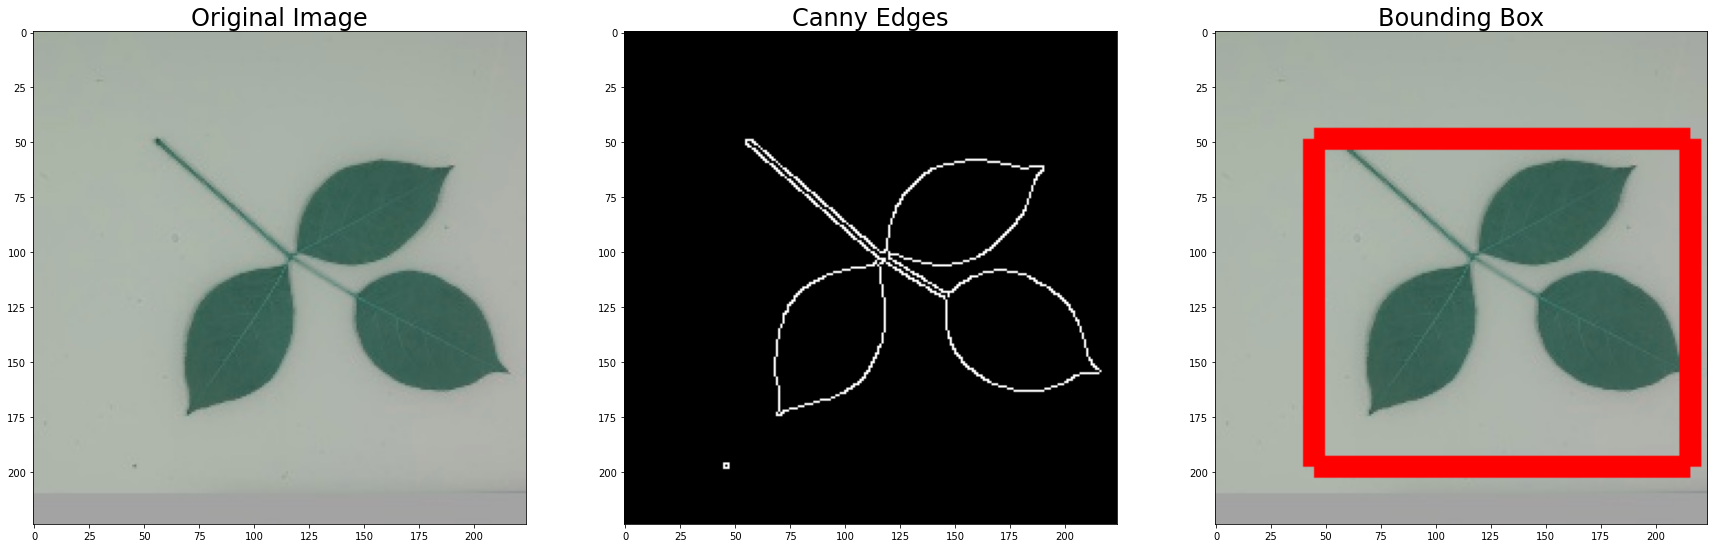

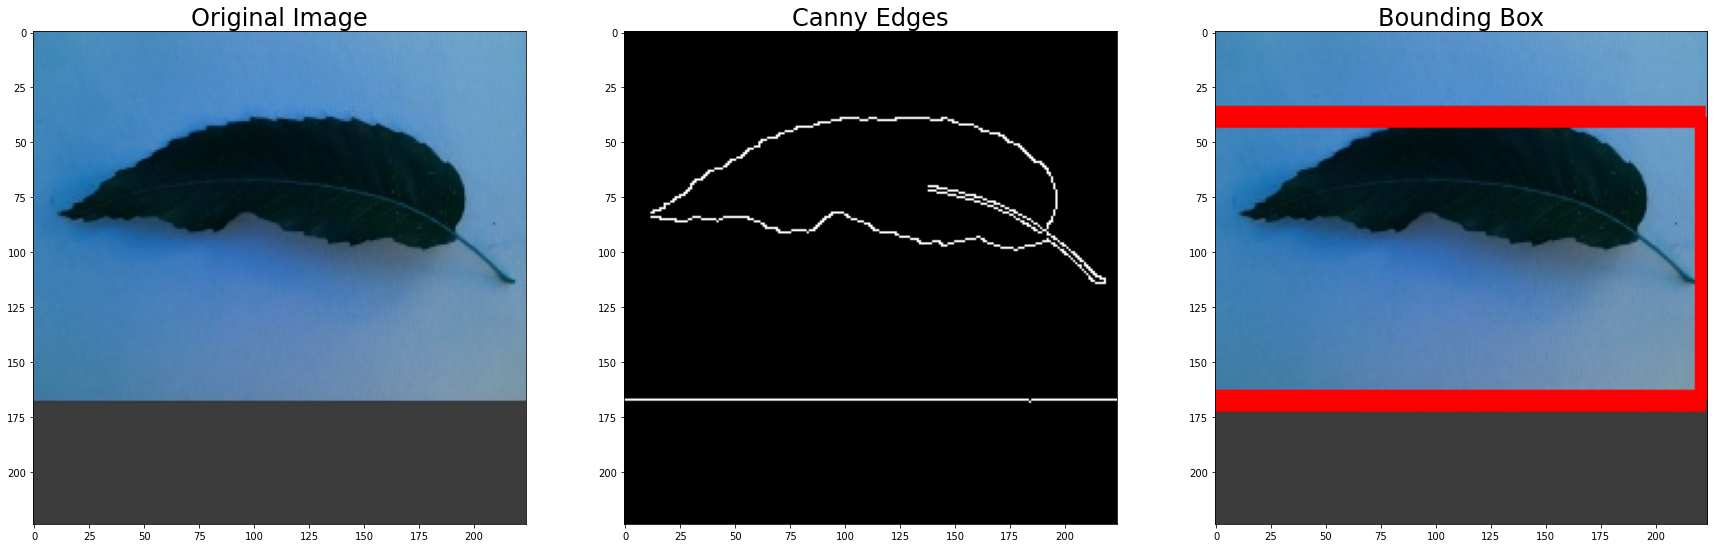

In [35]:
edge_and_cut('../input/classify-leaves/images/233.jpg')
edge_and_cut('../input/classify-leaves/images/2333.jpg')
edge_and_cut('../input/classify-leaves/images/25261.jpg')
# edge_and_cut('../input/classify-leaves/images/25909.jpg')
# edge_and_cut('../input/classify-leaves/images/26634.jpg')
# edge_and_cut('../input/classify-leaves/images/26723.jpg')

<a id="section-TWO"></a>
# Image Augmentation

有关Augmentation, 我们可以用pytorch自带的，也可以考虑使用albumentations lib.

The augmentation method can be divided as follows:
1. geometric transformations,  
2. color space transformations, 
3. kernel filters, 
4. mixing images,
5. random erasing

We should wisely choose and combine our augmentation method. Since some methods will increase your search space, 
and even dmage your performance.



通常图片的数据增强主要分为
1. 几何变换 2.颜色变换 3.滤镜化 4. 图片组合 5. 随机擦除

我们需要根据自己的目标数据集，合理的选择适合我们的数据增强方法，有些时候一些数据增强方法甚至会损害结果.

推荐大家看看这一篇 [A survey on Image Data Augmentation for Deep Learning](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0#Fun)

About mixup and cutmix https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu

<a id="subsection-albumentations"></a>
## Albumentations

In [36]:
from albumentations import (
    HorizontalFlip, VerticalFlip, Rotate, ShiftScaleRotate, RandomBrightnessContrast, Perspective, CLAHE, 
    Transpose, Blur, OpticalDistortion, GridDistortion, HueSaturationValue, ColorJitter, GaussNoise, MotionBlur, MedianBlur,
    Emboss, Sharpen, Flip, OneOf, SomeOf, Compose, Normalize, CoarseDropout, CenterCrop, GridDropout, Resize
)

In [37]:
# helper function
def get_img(imgsrc):
    im_bgr = cv2.imread(imgsrc)
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    return im_rgb

def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

In [38]:
 def plot_aug(img_src, method):
    img = get_img(img_src)
    augmented_img = method(p=1)(image=img)['image']
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(augmented_img)
    ax[1].set_title(method.__name__, fontsize=24)
    plt.show()

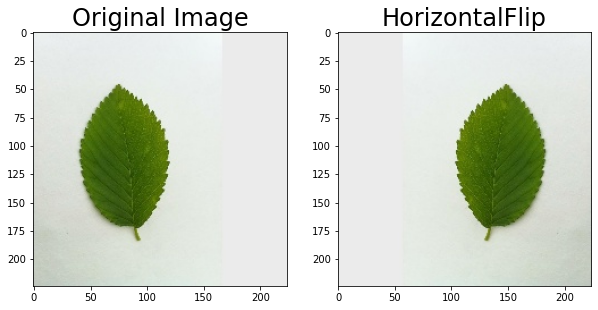

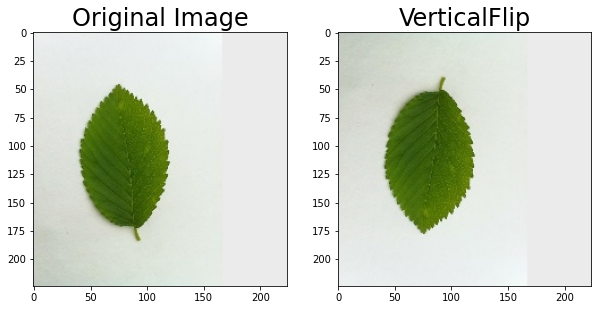

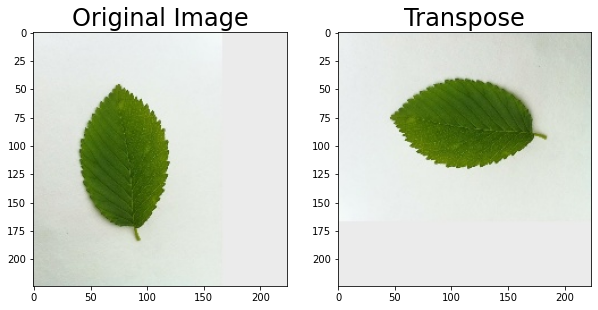

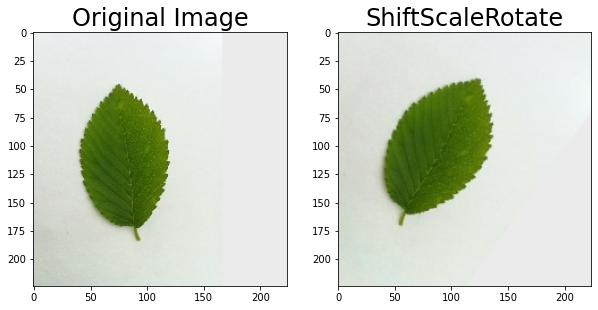

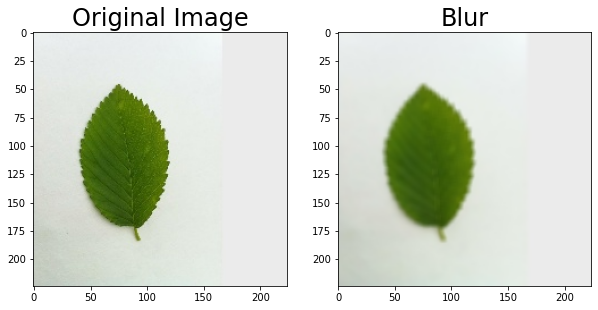

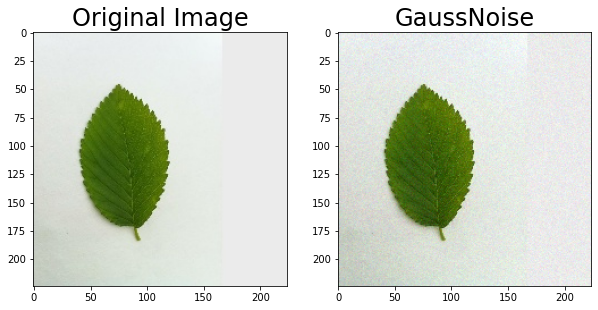

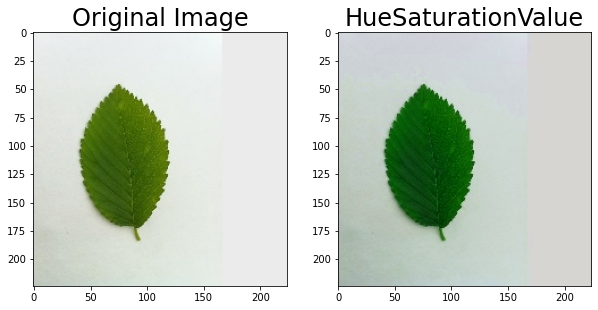

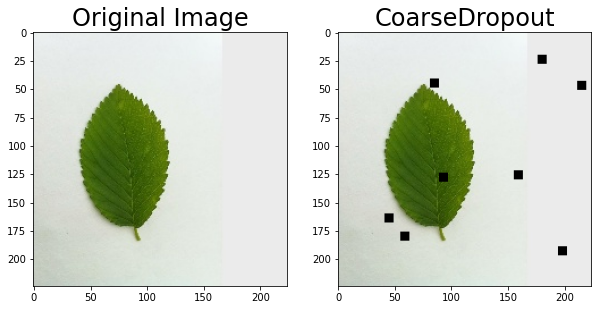

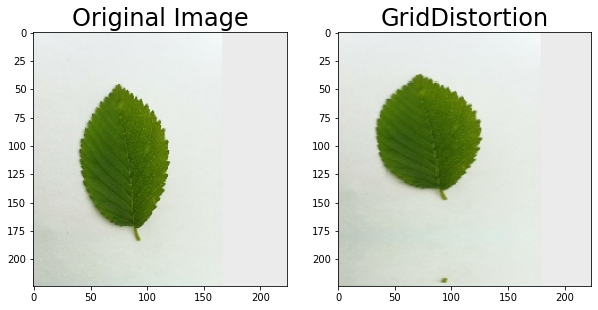

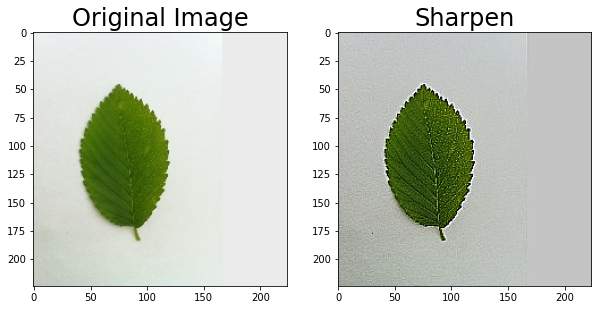

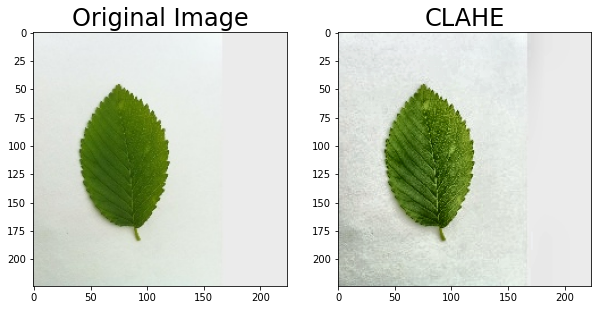

In [39]:
plot_aug('../input/classify-leaves/images/233.jpg', HorizontalFlip)
plot_aug('../input/classify-leaves/images/233.jpg', VerticalFlip)
plot_aug('../input/classify-leaves/images/233.jpg', Transpose)
plot_aug('../input/classify-leaves/images/233.jpg', ShiftScaleRotate)
plot_aug('../input/classify-leaves/images/233.jpg', Blur)
plot_aug('../input/classify-leaves/images/233.jpg', GaussNoise)
plot_aug('../input/classify-leaves/images/233.jpg', HueSaturationValue)
plot_aug('../input/classify-leaves/images/233.jpg', CoarseDropout)
plot_aug('../input/classify-leaves/images/233.jpg', GridDistortion)
plot_aug('../input/classify-leaves/images/233.jpg', Sharpen)
plot_aug('../input/classify-leaves/images/233.jpg', CLAHE)

### Common pipeline for augmentation

https://albumentations.readthedocs.io/en/latest/probabilities.html

https://albumentations.ai/docs/getting_started/setting_probabilities/

如果是使用 albumentations的话, 可以考虑合理使用 someof 和 oneof 和不同的 probability rate 来组合数据增强方法, 可以适当的减少搜索空间.

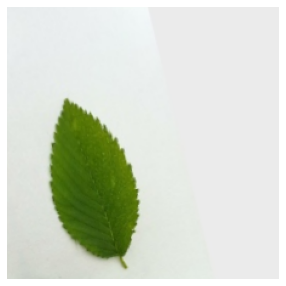

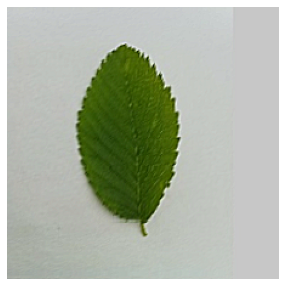

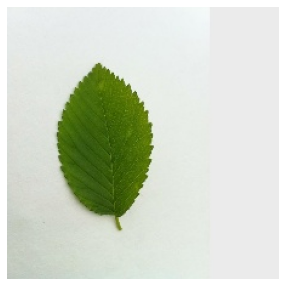

In [40]:
transform = Compose([
        SomeOf([
            Flip(),
            GridDistortion(),
            Transpose(),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        ], n=2, p=1),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
            GaussNoise(p=0.2),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            Sharpen(),
            Emboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        OneOf([
            CoarseDropout(),
            GridDropout(),
        ], p=0.2),
        HueSaturationValue(p=0.3),
    ])

img = get_img('../input/classify-leaves/images/233.jpg')

visualize(transform(image=img)['image'])
visualize(transform(image=img)['image'])
visualize(transform(image=img)['image'])

Most of the time, we use the normalization from ImageNet's [mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0]
but we can also make our own normalization data from our dataset.


大多数时候的normalization都使用Imagenet的就行了，但是我们也可以考虑自己计算 mean和 std. 或者使用其他的方法来做normalization 

比如：albumentations.augmentations.domain_adaptation.HistogramMatching

这里简单提一下两种自动选择augmentation方法.

<a id="subsection-autoaug"></a>
## AutoAlbument


Fast AutoAugment 
https://github.com/kakaobrain/fast-autoaugment

pip install -U autoalbument

https://github.com/albumentations-team/autoalbument

<a id="subsection-randomaug"></a>
## RandomAug

[RandAugment](https://arxiv.org/abs/1909.13719)

In [ ]:
#!pip install git+https://github.com/ildoonet/pytorch-randaugment

In [ ]:
#from RandAugment import RandAugment

In [ ]:
# from RandAugment import RandAugment

# N = 5
# M = 5

# train_transforms = Compose([
#             RandAugment(N, M),
#             Transpose(p=0.5),
#             VerticalFlip(p=0.5),
#             HorizontalFlip(p=0.5),
#             ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#             Resize(img_size[0], img_size[1], p=1.0),
#             #A.Normalize(),
#             #ToTensorV2(p=1.0),
#         ], p=1.0)

<a id="section-THREE"></a>
# Model

<a id="subsection-collection"></a>
## Model Collection

In [41]:
import os
import time
from glob import glob
import random

import pandas as pd
import numpy as np

import torch
from torch import nn

from torch.utils.data import Dataset,DataLoader
from torch.cuda.amp import autocast, GradScaler

import sklearn
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold

import cv2

from tqdm import tqdm

#import timm

In [42]:
!pip install timm
!pip install torchinfo

     |████████████████████████████████| 346 kB 419 kB/s eta 0:00:01


In [43]:
import timm
from torchinfo import summary

通常我们可以选择使用[torchvision.models](https://pytorch.org/vision/stable/models.html)来选择主流的模型. 

这里推荐使用timm库, 相比pytorch的官方库, 模型选择更多,也更新，可以查看很多模型参数细节. 

具体可以参考下面的链接. 可以通过torchinfo，辅助了解选择的模型.

https://paperswithcode.com/lib/timm


In [51]:
model_batch_size = 32

In [52]:
eff_model = timm.create_model('tf_efficientnet_b4', pretrained=True)
summary(eff_model, input_size = (model_batch_size, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  --                        --
├─Conv2dSame: 1-1                             [32, 48, 112, 112]        1,296
├─BatchNorm2d: 1-2                            [32, 48, 112, 112]        96
├─SiLU: 1-3                                   [32, 48, 112, 112]        --
├─Sequential: 1-4                             [32, 448, 7, 7]           --
│    └─Sequential: 2-1                        [32, 24, 112, 112]        --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 24, 112, 112]        2,940
│    │    └─DepthwiseSeparableConv: 3-2       [32, 24, 112, 112]        1,206
│    └─Sequential: 2-2                        [32, 32, 56, 56]          --
│    │    └─InvertedResidual: 3-3             [32, 32, 56, 56]          11,878
│    │    └─InvertedResidual: 3-4             [32, 32, 56, 56]          18,120
│    │    └─InvertedResidual: 3-5             [32, 32, 56, 56]          18,120

In [53]:
eff_model_2 = timm.create_model('tf_efficientnet_b5', pretrained=True)
summary(eff_model, input_size = (model_batch_size, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  --                        --
├─Conv2dSame: 1-1                             [32, 48, 112, 112]        1,296
├─BatchNorm2d: 1-2                            [32, 48, 112, 112]        96
├─SiLU: 1-3                                   [32, 48, 112, 112]        --
├─Sequential: 1-4                             [32, 448, 7, 7]           --
│    └─Sequential: 2-1                        [32, 24, 112, 112]        --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 24, 112, 112]        2,940
│    │    └─DepthwiseSeparableConv: 3-2       [32, 24, 112, 112]        1,206
│    └─Sequential: 2-2                        [32, 32, 56, 56]          --
│    │    └─InvertedResidual: 3-3             [32, 32, 56, 56]          11,878
│    │    └─InvertedResidual: 3-4             [32, 32, 56, 56]          18,120
│    │    └─InvertedResidual: 3-5             [32, 32, 56, 56]          18,120

In [54]:
res_model = timm.create_model('resnest50d', pretrained=True)
res_model.fc = nn.Linear(2048, 176)
summary(res_model, input_size = (model_batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Sequential: 1-1                        [32, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 32, 112, 112]        864
│    └─BatchNorm2d: 2-2                  [32, 32, 112, 112]        64
│    └─ReLU: 2-3                         [32, 32, 112, 112]        --
│    └─Conv2d: 2-4                       [32, 32, 112, 112]        9,216
│    └─BatchNorm2d: 2-5                  [32, 32, 112, 112]        64
│    └─ReLU: 2-6                         [32, 32, 112, 112]        --
│    └─Conv2d: 2-7                       [32, 64, 112, 112]        18,432
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └

In [48]:
del eff_model
del eff_model_2
del res_model

We can use summary to estimate our GPU RAM consumption with different settings


<a id="section-FOUR"></a>
# Train Loop

## Config

In [ ]:
CFG = {
    'rootdir': '../input/classify-leaves/',
    'fold_num': 5,
    'seed': 123,
    'model_arch': 'tf_efficientnet_b5',
    'img_size': 224,
    'epochs': 10,
    'train_bs': 32,
    'valid_bs': 32,
    'T_0': 10, # Number of iterations for the first restart
    'lr': 3e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 8,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1, # 0 (silent),1 (progress bar), 2 (one line per epoch)
    'device': 'cuda:0'
}

## Helper Function

In [ ]:
# labelencoder for dataset
t_labelencoder = preprocessing.LabelEncoder()
t_labelencoder.fit(train['label'])

In [ ]:
train_clean['label'] = t_labelencoder.transform(train_clean['label'])

In [ ]:
train_clean

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

## Prepare Data

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df, data_root, transforms=None, output_label=True):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        
        self.output_label = output_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.output_label == True:
            return img, target
        else:
            return img

Augmentation

In [ ]:
from albumentations import (
    HorizontalFlip, VerticalFlip, Rotate, ShiftScaleRotate, RandomBrightnessContrast, Perspective, CLAHE, 
    Transpose, Blur, OpticalDistortion, GridDistortion, HueSaturationValue, ColorJitter, GaussNoise, MotionBlur, MedianBlur,
    Emboss, Sharpen, Flip, OneOf, SomeOf, Compose, Normalize, CoarseDropout, CenterCrop, GridDropout, Resize
)
from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            OneOf([
            CoarseDropout(p=0.5),
            GaussNoise(),
            ], p=0.5),
            SomeOf([
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            ], n=3, p=0.6),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
  
        
def get_valid_transforms():
    return Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [ ]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='../classify-leaves/'):

    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = MyDataset(train_, data_root, transforms=get_train_transforms(), output_label=True)
    valid_ds = MyDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

## Model

In [ ]:
class EfficientModel(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)

    def forward(self, x):
        x = self.model(x)
        return x
    
class ResnetModel(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

## Training

In [ ]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None):
    model.train()

    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        with autocast():
            image_preds = model(imgs)

            loss = loss_fn(image_preds, image_labels)
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
                
    if scheduler is not None:
        scheduler.step()
        
    return running_loss
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None):
    model.eval()

    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    val_loss = None
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            val_loss = loss_sum/sample_num
            description = f'epoch {epoch} loss: {val_loss:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    val_acc = (image_preds_all==image_targets_all).mean()
    print('validation multi-class accuracy = {:.4f}'.format(val_acc))
    
    if scheduler is not None:
        scheduler.step()
        
    return val_acc, val_loss

## Main Loop

In [ ]:
if __name__ == '__main__':

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train_clean.shape[0]), train_clean.label.values)
    train_loss_all = []
    val_loss_all = []
    val_acc_all = []
    for fold, (trn_idx, val_idx) in enumerate(folds):
        start_time = time.time()
        # 测试两个fold
        if fold > 1:
            break 
            
        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train_clean, trn_idx, val_idx, data_root=CFG['rootdir'])

        device = torch.device(CFG['device'])
        
        model = EfficientModel(CFG['model_arch'], train_clean.label.nunique(), pretrained=True).to(device)
        scaler = GradScaler()   
        optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
        
        loss_tr = nn.CrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        train_loss_temp = []
        val_loss_temp = [] 
        val_acc_temp = []
        
        for epoch in range(CFG['epochs']):
            train_loss_temp = train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler)
            train_loss_all.append([fold, epoch, train_loss_temp])
            with torch.no_grad():
                val_acc_temp, val_loss_temp = valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None)
                
                val_loss_all.append([fold, epoch, val_loss_temp])
                val_acc_all.append([fold, epoch, val_acc_temp])
            if epoch > CFG['epochs'] - 4:  #save last three models
                torch.save(model.state_dict(),'{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
                
        del model, optimizer, train_loader, val_loader, scaler, scheduler
        torch.cuda.empty_cache()

## Plot the result

In [ ]:
train_loss_all_df = pd.DataFrame(np.array(train_loss_all), columns = ['fold','epoch','train_loss'])
val_loss_all_df = pd.DataFrame(np.array(val_loss_all), columns = ['fold','epoch','val_loss'])
val_acc_all_df = pd.DataFrame(np.array(val_acc_all), columns = ['fold','epoch','val_acc'])

In [ ]:
fig1 = px.line(train_loss_all_df, x="epoch", y="train_loss", color='fold')
fig2 = px.line(val_loss_all_df, x="epoch", y="val_loss", color='fold')
fig3 = px.line(val_acc_all_df, x="epoch", y="val_acc", color='fold')
fig4 = go.Figure(data=fig1.data + fig2.data + fig3.data)
fig4.show()

<a id="section-FIVE"></a>
# Inference Loop

In [ ]:
CFG['weights'] = [0.8,1,0.9] # weight for out model
CFG['tta'] = 3 # set TTA times
CFG['used_epochs'] = [7,8,9] # choose the model

CFG

In [ ]:
def get_inference_transforms():
    return Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            #HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            #RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [ ]:
def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        
        image_preds = model(imgs)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
        
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [ ]:
if __name__ == '__main__':
    
    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num']).split(np.arange(train_clean.shape[0]), train_clean.label.values)
    tst_preds_all = []
    for fold, (trn_idx, val_idx) in enumerate(folds):
        
        if fold > 1:
            break

        print('Inference fold {} started'.format(fold))
        
        valid_ = train_clean.loc[val_idx,:].reset_index(drop=True)
        valid_ds = MyDataset(valid_, CFG['rootdir'], transforms=get_inference_transforms(), output_label=False)

        test = pd.read_csv( CFG['rootdir'] + 'test.csv')
        test_ds = MyDataset(test, CFG['rootdir'], transforms=get_inference_transforms(), output_label=False)

        val_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=True,
        )

        tst_loader = torch.utils.data.DataLoader(
            test_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=True,
        )
        
        device = torch.device(CFG['device'])
        model = EfficientModel(CFG['model_arch'], train.label.nunique()).to(device)
        
        val_preds = []
        tst_preds = []
        
        for i, epoch in enumerate(CFG['used_epochs']):    
            model.load_state_dict(torch.load('{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch)))
            
            with torch.no_grad():
                for _ in range(CFG['tta']):
                    val_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, val_loader, device)]
                    tst_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, tst_loader, device)]

                    
        val_preds = np.mean(val_preds, axis=0) 
        tst_preds = np.mean(tst_preds, axis=0) 
        tst_preds_all.append(tst_preds)
        
        print('fold {} validation loss = {:.5f}'.format(fold, log_loss(valid_.label.values, val_preds)))
        print('fold {} validation accuracy = {:.5f}'.format(fold, (valid_.label.values==np.argmax(val_preds, axis=1)).mean()))
        del model
        torch.cuda.empty_cache()

In [ ]:
# calculate the average result from all folds
avg_tst = np.mean(tst_preds_all, axis=0)

In [ ]:
test['label'] = np.argmax(avg_tst, axis=1)
test.head()

In [ ]:
# inverse our label
test['label'] = t_labelencoder.inverse_transform(test['label'])

In [ ]:
test.to_csv('submission.csv', index=False)